tutorial from https://medium.com/analytics-vidhya/ml-classification-algorithms-to-predict-market-movements-and-backtesting-2382fdaf7a32

In [1]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
from math import floor

# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/wu/.local/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# ticker and the start and end dates for testing
ticker =  '2800.HK'
start = datetime.datetime(2010, 1, 15)
end = datetime.datetime(2020, 1, 15)
# download ticker 'Open' price from yahoo finance
stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Open']
stock = pd.DataFrame(stock)
stock.rename(columns = {'Open': ticker}, inplace=True)
stock.head()

[*********************100%***********************]  1 of 1 completed


,2800.HK
Date,
2010-01-15,21.900000
2010-01-18,21.600000
2010-01-19,21.700001
2010-01-20,21.799999
2010-01-21,21.299999


In [3]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head()

,2800.HK,returns,direction
Date,,,
2010-01-18,21.600000,-0.013793,-1
2010-01-19,21.700001,0.004619,1
2010-01-20,21.799999,0.004598,1
2010-01-21,21.299999,-0.023203,-1
2010-01-22,20.600000,-0.033416,-1


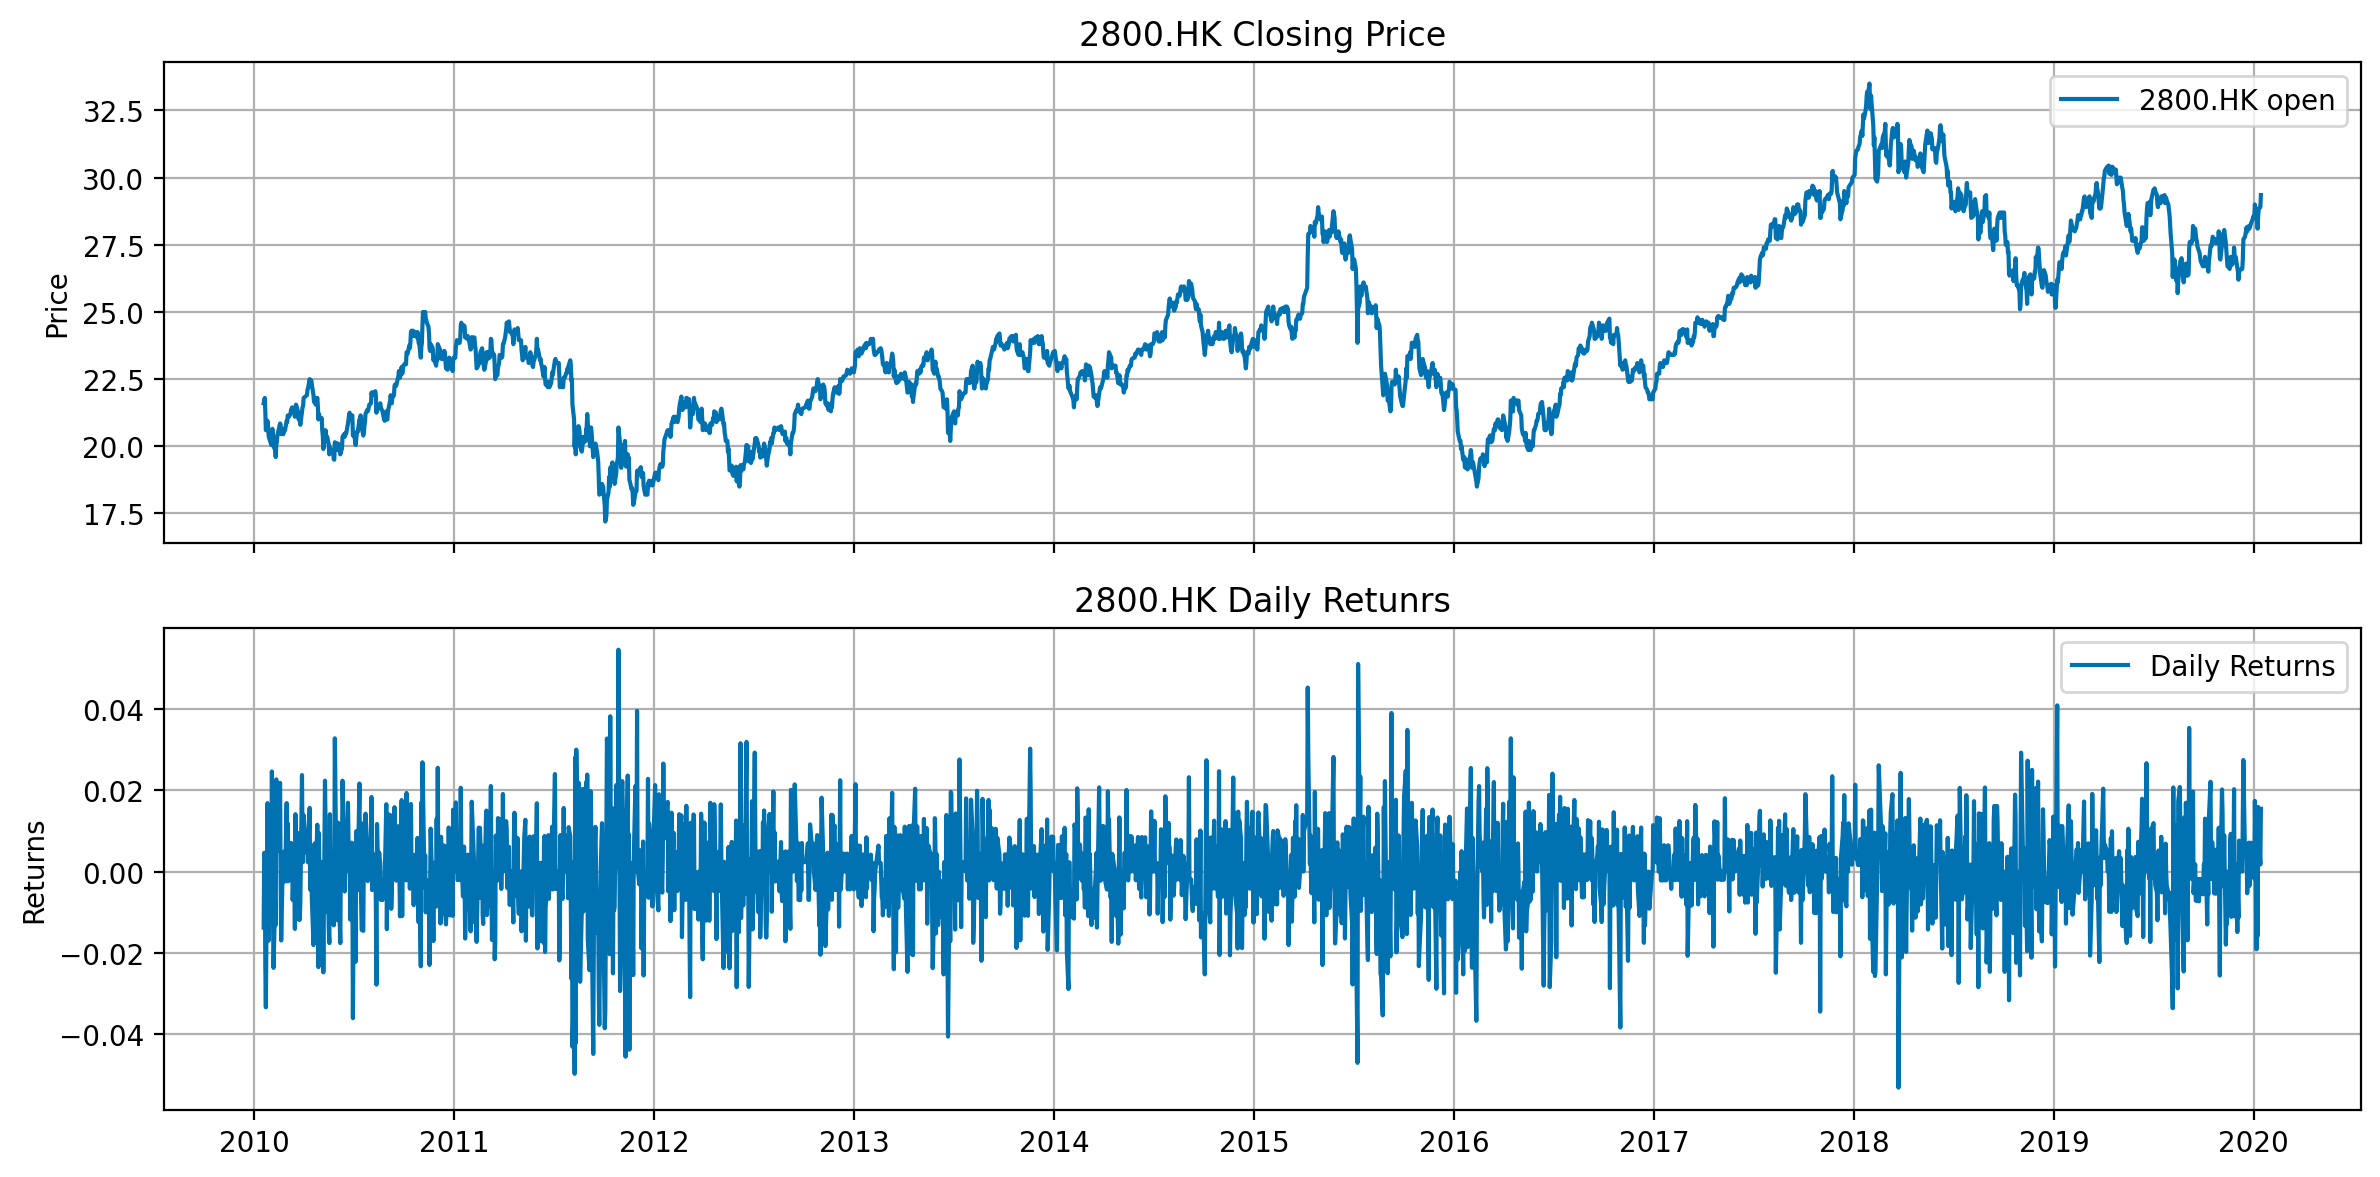

In [4]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} open')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()
ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()
plt.tight_layout()

In [5]:
# define the number of lags
lags = [1, 2, 3, 4, 5]

# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)
stock.dropna(inplace=True)
stock.head()

,2800.HK,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
Date,,,,,,,,
2010-01-25,20.950001,0.016848,1,-0.033416,-0.023203,0.004598,0.004619,-0.013793
2010-01-26,20.750000,-0.009592,-1,0.016848,-0.033416,-0.023203,0.004598,0.004619
2010-01-27,20.400000,-0.017011,-1,-0.009592,0.016848,-0.033416,-0.023203,0.004598
2010-01-28,20.299999,-0.004914,-1,-0.017011,-0.009592,0.016848,-0.033416,-0.023203
2010-01-29,20.250000,-0.002466,-1,-0.004914,-0.017011,-0.009592,0.016848,-0.033416


In [6]:
# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)
create_bins(stock)
stock[["returns","direction"]+cols+cols_bin].head()

,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
Date,,,,,,,,,,,,
2010-01-25,0.016848,1,-0.033416,-0.023203,0.004598,0.004619,-0.013793,0,0,1,1,0
2010-01-26,-0.009592,-1,0.016848,-0.033416,-0.023203,0.004598,0.004619,1,0,0,1,1
2010-01-27,-0.017011,-1,-0.009592,0.016848,-0.033416,-0.023203,0.004598,0,1,0,0,1
2010-01-28,-0.004914,-1,-0.017011,-0.009592,0.016848,-0.033416,-0.023203,0,0,1,0,0
2010-01-29,-0.002466,-1,-0.004914,-0.017011,-0.009592,0.016848,-0.033416,0,0,0,1,0



Total Returns: 

returns                   1.424757
strategy_log_reg          1.712071
strategy_gauss_nb         1.712071
strategy_svm              4.623121
strategy_random_forest    4.862217
strategy_MLP              4.163486
dtype: float64

Annual Volitility:
returns                   0.178327
strategy_log_reg          0.178308
strategy_gauss_nb         0.178308
strategy_svm              0.178068
strategy_random_forest    0.178049
strategy_MLP              0.178104
dtype: float64
Number of trades SVM =  659
Number of trades Ramdom Forest =  1031


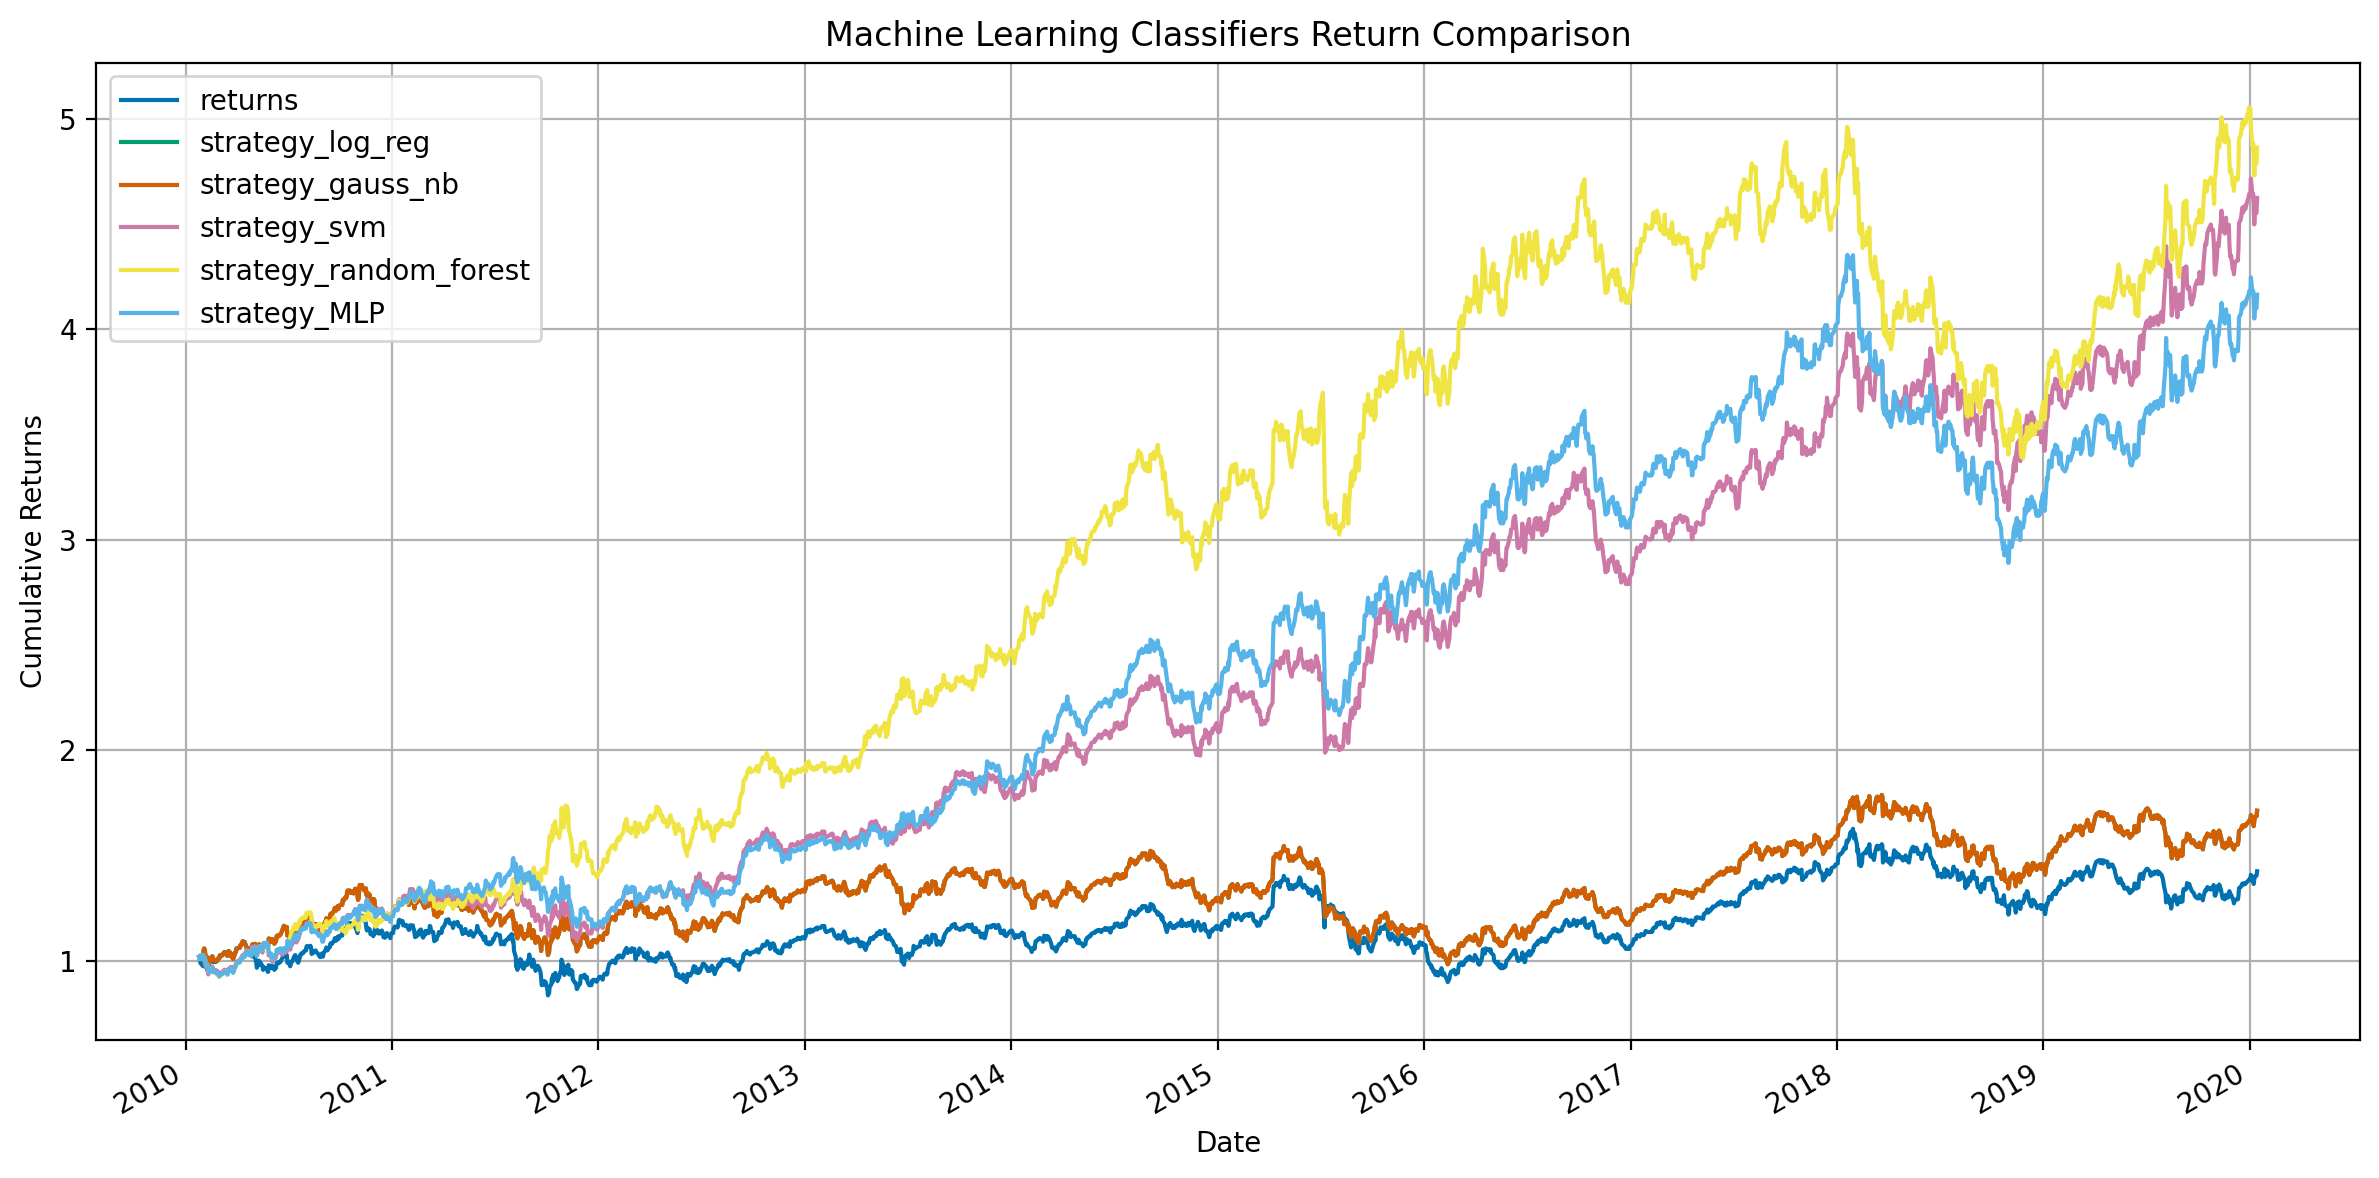

In [7]:
# create a dictionary of selected algorithms
models = {
 'log_reg': linear_model.LogisticRegression(),
 'gauss_nb': GaussianNB(),
 'svm': SVC(),
 'random_forest': RandomForestClassifier(max_depth=10, n_estimators=100),
 'MLP' : MLPClassifier(max_iter=500),
}
# function that fits all models.
def fit_models(data):  
    mfit = {
        model: models[model].fit(
            data[cols_bin], 
            data['direction']) 
            for model in models.keys()
        }
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])
# function to evaluate all trading strategies
def evaluate_strats(data):  
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model 
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')
# fit the models
fit_models(stock)
# derives all position values
derive_positions(stock)
# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)
# calculate total return and std. deviation of each strategy
print('\nTotal Returns: \n')
print(stock[strategy_rtn].sum().apply(np.exp))
print('\nAnnual Volitility:')
print(stock[strategy_rtn].std() * 252 ** 0.5)
# number of trades over time for highest and second highest return strategy
print('Number of trades SVM = ', (stock['pos_svm'].diff()!=0).sum())
print('Number of trades Ramdom Forest = ',(stock['pos_random_forest'].diff()!=0).sum())
# vectorized backtesting of the resulting trading strategies and visualize the performance over time
ax = stock[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), 
                                                     title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel("Cumulative Returns")
ax.grid(True)
plt.tight_layout()

In [8]:
# fetch the daily pricing data from yahoo finance
prices = yf.download(ticker, progress=True, actions=True, start=start, end=end)
# rename the columns as needed for Backtrader
prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume'}, inplace=True)
prices.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
Date,,,,,
2010-01-15,21.900000,21.950001,21.700001,21.750000,4150191
2010-01-18,21.600000,21.799999,21.450001,21.600000,6957523
2010-01-19,21.700001,21.850000,21.500000,21.799999,6903721
2010-01-20,21.799999,21.799999,21.299999,21.400000,13918030
2010-01-21,21.299999,21.450001,20.950001,21.000000,16467130


In [9]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = stock['pos_random_forest']
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'pos_random_forest':'predicted'}, inplace=True)
predictions=predictions.shift(-1)
prices = predictions.join(prices, how='left').dropna()
prices.head()

,predicted,open,high,low,close,volume
Date,,,,,,
2010-01-25,1.0,20.950001,20.950001,20.549999,20.750000,14430700
2010-01-26,-1.0,20.750000,20.750000,20.200001,20.299999,22480900
2010-01-27,1.0,20.400000,20.500000,20.049999,20.200001,10325660
2010-01-28,1.0,20.299999,20.600000,20.299999,20.500000,8286605
2010-01-29,-1.0,20.250000,20.500000,20.049999,20.250000,13750950


In [10]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']
    # create lines
    lines = tuple(cols)
    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [11]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict()
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')
        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f'Order Failed: {order.status}')
        # set no pending order
        self.order = None
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if self.data_predicted > 0:
            # calculate the max number of shares ('all-in')
            size = int(self.broker.getcash() / self.datas[0].open)
            if size > 0:
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        if self.data_predicted < 0 and self.position:
            # sell order
            size = self.position.size * 1
            self.log(f'SELL CREATED --- Size: {size}')
            self.sell(size=size)
            

In [12]:
# instantiate SignalData class
data = SignalData(dataname=prices)
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
type(self.data_predicted): <class 'backtrader.linebuffer.LineBuffer'>
type(self.data_predicted): <class 'backtrader.linebuffer.LineBuffer'>
type(self.data_predicted): <class 'backtrader.linebuffer.LineBuffer'>
2010-01-27, BUY CREATED --- Size: 4901, Cash: 100000.00, Open: 20.399999618530273, Close: 20.200000762939453
2010-01-27, BUY EXECUTED --- Price: 20.40, Cost: 99980.40,Commission: 0.00
type(self.data_predicted): <class 'backtrader.linebuffer.LineBuffer'>
type(self.data_predicted): <class 'backtrader.linebuffer.LineBuffer'>
2010-01-29, SELL CREATED --- Size: 4901
2010-01-29, SELL EXECUTED --- Price: 20.25, Cost: 99980.40,Commission: 0.00
2010-01-29, OPERATION RESULT --- Gross: -735.15, Net: -735.15
type(self.data_predicted): <class 'backtrader.linebuffer.LineBuffer'>
type(self.data_predicted): <class 'backtrader.linebuffer.LineBuffer'>
2010-02-02, BUY CREATED --- Size: 4830, Cash: 99264.85, Open: 20.549999237060547, Close: 20.450000762939453
2010

In [13]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = ticker

In [14]:
# get performance statistics for strategy
pf.show_perf_stats(returns)

Start date,2010-01-25
End date,2020-01-13
Total months,117
,Backtest
Annual return,10.3%
Cumulative returns,159.5%
Annual volatility,15.3%
Sharpe ratio,0.72
Calmar ratio,0.37
Stability,0.91
Max drawdown,-27.7%


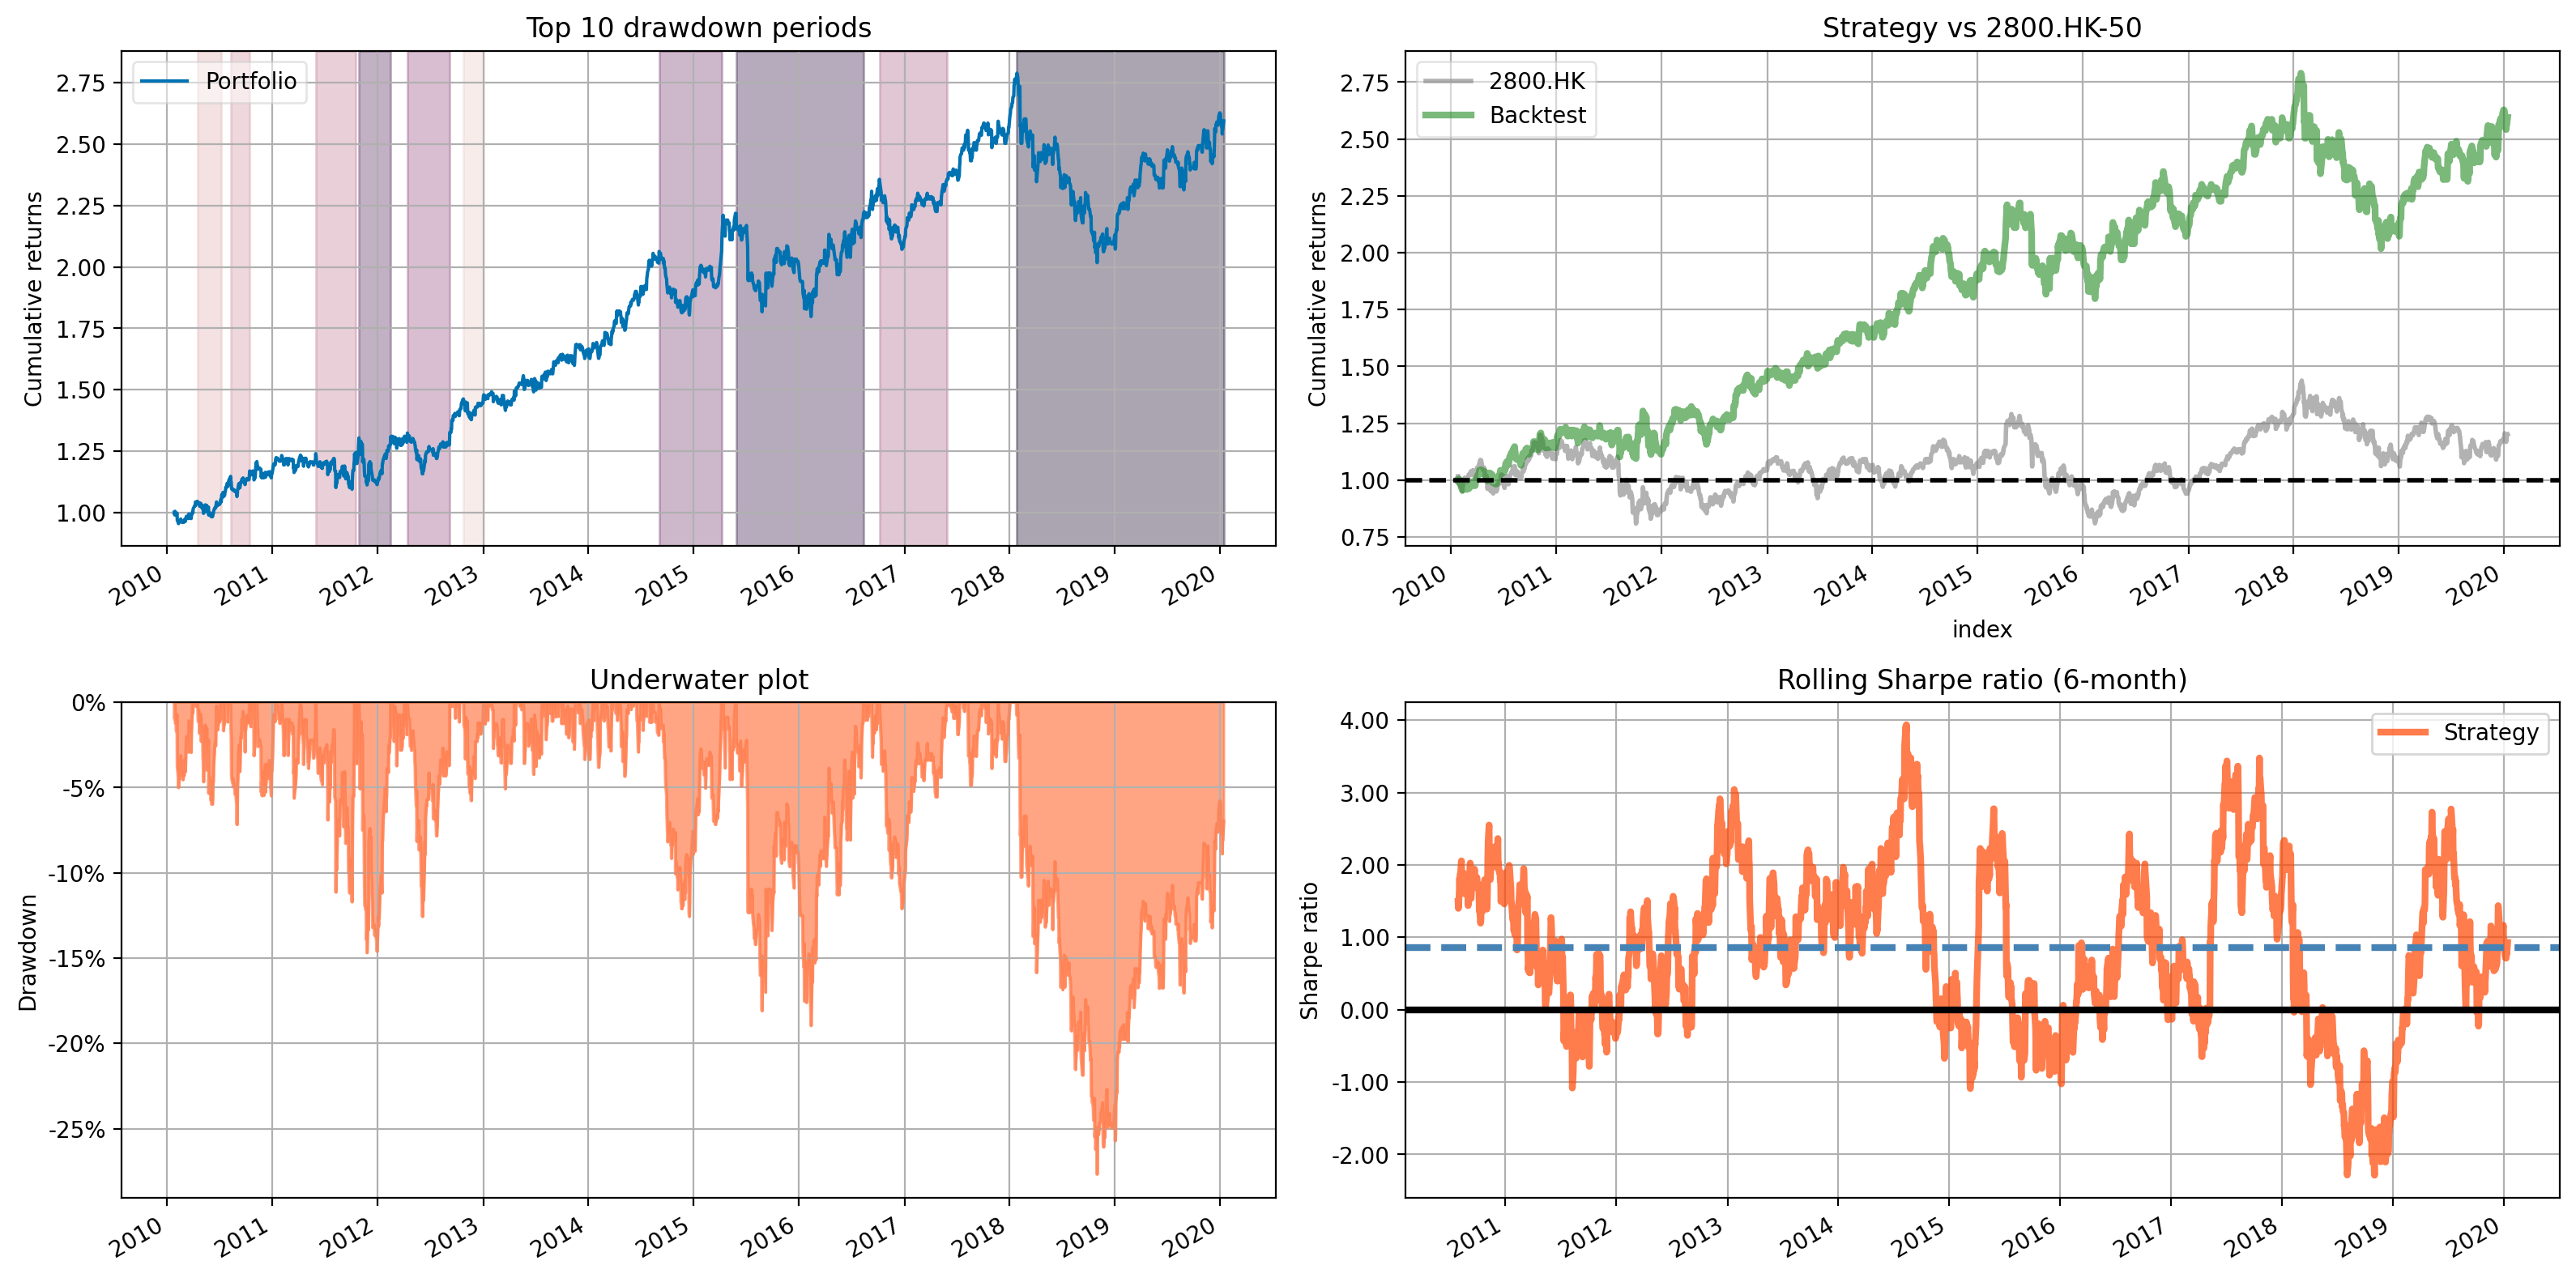

In [15]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8),constrained_layout=True)
axes = ax.flatten()
pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title=f'Strategy vs {ticker}-50')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)

plt.grid(True)
plt.legend()
plt.tight_layout()